In [1]:
import os
import sys
sys.path.append('../')

import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches  

from models.interaction_network import InteractionNetwork
from models.graph import Graph, save_graphs, load_graph
from models.dataset import Dataset

In [2]:
plt.rc('font', family='dejavuserif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)

In [6]:
def draw_graph_rz(X, Ri, Ro, y, out,                   
                  cut=0.5, savefig=False, filename='out.png'):
    
    X = X.transpose()
    feats_o = Ro @ X
    feats_i = Ri @ X
    
    fig = plt.figure(dpi=200)
    ax = fig.add_subplot(111)
    ax.scatter(X[:,2], X[:,0], c='silver', lw=0, marker='s', s=8)
    
    true_pos = ((out>cut) & (y>0.5))
    true_neg = ((out<cut) & (y<0.5))
    wrong = (((out<cut) & (y>0.5)) | ((out>cut) & (y<0.5)))
    ax.plot((feats_o[true_pos][:,2], feats_i[true_pos][:,2]),
            (feats_o[true_pos][:,0], feats_i[true_pos][:,0]),
            'go-', lw=0.1, ms=0.0, alpha=0.5)
    ax.plot((feats_o[true_neg][:,2], feats_i[true_neg][:,2]),
            (feats_o[true_neg][:,0], feats_i[true_neg][:,0]),
            'ko-', lw=0.05, ms=0.0, alpha=0.05)
    ax.plot((feats_o[wrong][:,2], feats_i[wrong][:,2]),
            (feats_o[wrong][:,0], feats_i[wrong][:,0]),
            'ro-', lw=0.1, ms=0.0, alpha=0.8)

    green_patch = mpatches.Patch(color='green', label='TP')
    black_patch = mpatches.Patch(color='black', label='TN')
    red_patch = mpatches.Patch(color='red', label='FN or FP')
    ax.legend(handles=[green_patch, black_patch, red_patch], loc='lower right')
    ax.set_ylabel("r [m]")
    ax.set_xlabel("z [m]")
    ax.set_xlim([-1.6, 1.6])
    ax.set_ylim([0, 0.2])
    if (savefig): plt.savefig(filename, dpi=1200)
    plt.show()

In [7]:
construction, pt = 'heptrkx_plus', '1'
graph_indir = "../..//hitgraphs/{}_{}/".format(construction, pt)
graph_files = np.array(os.listdir(graph_indir))
n_graphs = len(graph_files)

IDs = np.arange(n_graphs)
np.random.shuffle(IDs)
partition = {'train': graph_files[IDs[:1000]],  
             'test':  graph_files[IDs[1000:1400]],
             'val': graph_files[IDs[1400:1500]]}

params = {'batch_size': 1, 'shuffle': True, 'num_workers': 6}
test_set = Dataset(graph_indir, partition['test']) 
test_loader = torch.utils.data.DataLoader(test_set, **params)

0.008244482800364494


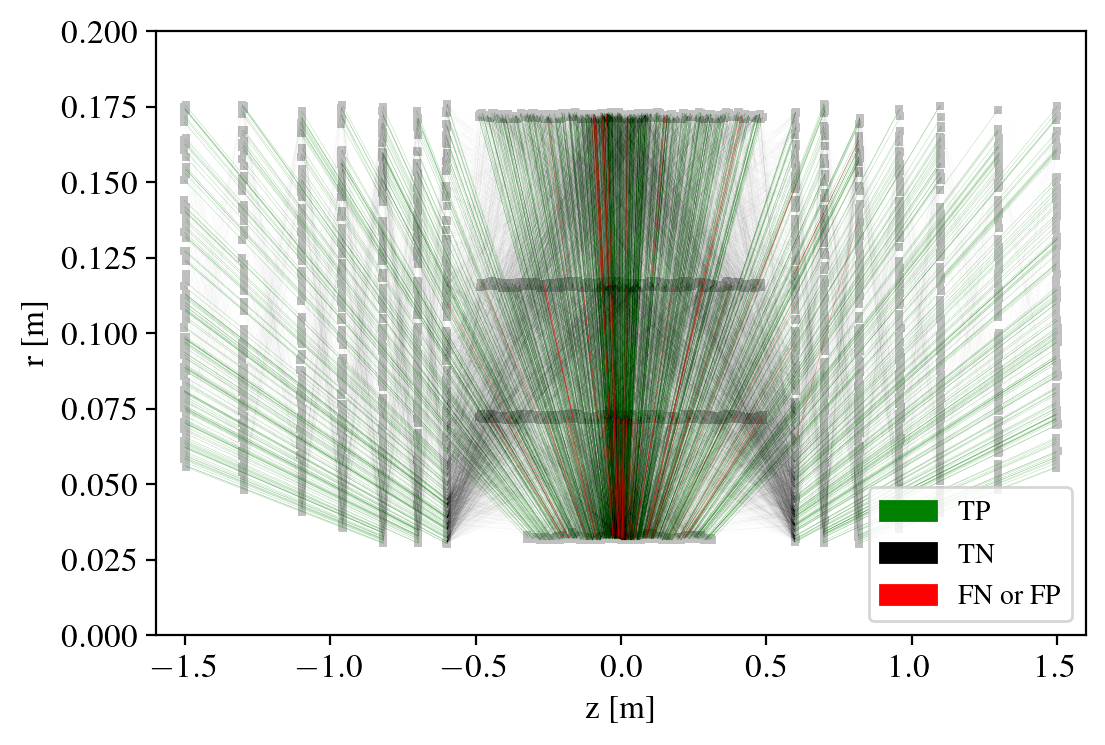

In [8]:
criterion = nn.BCELoss()
interaction_network = InteractionNetwork(3, 4, 4)
losses, epochs = [], []
model='../heptrkx_plus_epoch18_1GeV.pt'
interaction_network.load_state_dict(torch.load(model))
interaction_network.eval()
for batch_idx, (graph, target) in enumerate(test_loader):
    X, Ra = graph['X'], graph['Ra']
    Ri, Ro = graph['Ri'], graph['Ro']
    predicted = interaction_network(X, Ra.float(), Ri.float(), Ro.float())
    predicted = predicted.squeeze(2)
    loss = (criterion(predicted, target))
    losses.append(loss.item())
    print(loss.item())
    draw_graph_rz(X.detach().numpy()[0], Ri.detach().numpy()[0], 
                  Ro.detach().numpy()[0], target.detach().numpy()[0], 
                  predicted.detach().numpy()[0], cut=0.5, savefig=True,
                  filename='train_classified_edges.png')
    break
